In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, AutoEncoderDataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso

Using TensorFlow backend.
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aaronwu/.conda/envs/tfg

In [2]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)
keras.__version__

'2.1.6'

In [3]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# "A" (Koopman Approximation) and "B" (recurrent actuator weights) Visualization

In [4]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    #state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
    #                      model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
    #                     name='state_decoder')    
    #control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
    #                        model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
    #                        name='control_decoder')
 
    return state_encoder, state_decoder, control_encoder #, control_decoder

def plot_autoencoder_AB(model,scenario, filename=None, **kwargs):
    
    A,B = get_AB(model)
    f, axes = plt.subplots(1, 2, figsize=(28, 14),
                           gridspec_kw={'width_ratios': [scenario['state_latent_dim'], 
                                                         scenario['control_latent_dim']]})
    sns.heatmap(A, 
                cmap=kwargs.get('cmap','Spectral'),
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[0]).set_title('A')
    sns.heatmap(B,
                cmap=kwargs.get('cmap','Spectral'), 
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[1]).set_title('B')

    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

# Eigenvalue plots of A matrix

In [5]:
def plot_autoencoder_spectrum(model,scenario, filename=None, **kwargs):

    font={'family': 'DejaVu Serif',
          'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
    
    dt = scenario['dt']
    A,B = get_AB(model)
    eigvals, eigvecs = np.linalg.eig(A)
    logeigvals = np.log(eigvals)
    for i, elem in enumerate(logeigvals):
        if abs(np.imag(elem)-np.pi)<np.finfo(np.float32).resolution:
            logeigvals[i] = np.real(elem) + 0j
    logeigvals = logeigvals/dt

    f, axes = plt.subplots(1, 2, figsize=(28, 14))
    axes[0].scatter(np.real(eigvals),np.imag(eigvals))
    t = np.linspace(0,2*np.pi,1000)
    axes[0].plot(np.cos(t),np.sin(t))

    axes[0].set_title('Eigenvalues of A')
    axes[0].grid(color='gray')
    axes[0].set_xlabel('Re($\lambda$)')
    axes[0].set_ylabel('Im($\lambda$)')


    axes[1].scatter(np.real(logeigvals),np.imag(logeigvals))
    axes[1].set_title('Eigenvalues of A')
    axes[1].grid(color='gray')
    axes[1].set_xlabel('Growth Rate (1/s)')
    axes[1].set_ylabel('$\omega$ (rad/s)')
    axes[1].set_xlim((1.1*np.min(np.real(logeigvals)),np.maximum(1.1*np.max(np.real(logeigvals)),0)))
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

# Autoencoder Training Plots

In [6]:
def plot_autoencoder_training(model,scenario,filename=None,**kwargs):

    f, axes = plt.subplots(2, 2, figsize=(28, 28))
    axes[0,0].semilogy(scenario['history']['loss'],label='train')
    axes[0,0].semilogy(scenario['history']['val_loss'],label='val')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()
    
    axes[0,1].semilogy(scenario['history']['x_residual_mean_squared_error'],label='train')
    axes[0,1].semilogy(scenario['history']['val_x_residual_mean_squared_error'],label='val')
    axes[0,1].set_title('X residual MSE')
    axes[0,1].legend()
    '''
    axes[1,0].semilogy(scenario['history']['u_residual_mean_squared_error'],label='train')
    axes[1,0].semilogy(scenario['history']['val_u_residual_mean_squared_error'],label='val')
    axes[1,0].set_title('U residual MSE')
    axes[1,0].legend()
    '''
    axes[1,1].semilogy(scenario['history']['linear_system_residual_mean_squared_error'],label='train')
    axes[1,1].semilogy(scenario['history']['val_linear_system_residual_mean_squared_error'],label='val')
    axes[1,1].set_title('Linear Model MSE')
    axes[1,1].legend()
    
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        

# Observability and Controlability Analysis

In [7]:
def stabAnalysis(model, scenario, filename = None):
    A,B = get_AB(model)
    dt = .05
    # Ac = logm(Ad)/dt
    Ac = scipy.linalg.logm(A)/dt
    # Bc = inv(Ad-I)*Ac*Bd
    Bc = np.matmul(np.linalg.inv(A-np.eye(scenario['state_latent_dim'])),np.matmul(Ac,B))
    C = np.eye(scenario['state_latent_dim'])
    D = np.zeros((scenario['state_latent_dim'],scenario['control_latent_dim']))

    Wcc = scipy.linalg.solve_continuous_lyapunov(Ac,-Bc.dot(Bc.T))
    Wdc = scipy.linalg.solve_discrete_lyapunov(A,B.dot(B.T))

    Wco = scipy.linalg.solve_continuous_lyapunov(Ac.T,-C.dot(C.T)).T
    Wdo = scipy.linalg.solve_discrete_lyapunov(A.T,C.dot(C.T)).T

    fig = plt.figure(figsize=(28,14))
    plt.subplot(1,2,1,title='Wcc, Wdc')
    plt.semilogy(np.linalg.svd(Wcc,compute_uv=False), label ='wcc')
    plt.semilogy(np.linalg.svd(Wdc,compute_uv=False), label = 'wdc')
    plt.legend(loc='best')

    plt.subplot(1,2,2, title = 'Wco, Wdo')
    plt.semilogy(np.linalg.svd(Wco,compute_uv=False),label = 'wco')
    plt.semilogy(np.linalg.svd(Wdo,compute_uv=False), label = 'wdo')

    plt.legend(loc='best')
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    
    return fig

# Plot State and Control Residuals for Specified Shot

In [41]:
def get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,shot,timestep,**kwargs):
    import numpy as np
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs['input_'+sig][:,0,:].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs['input_'+sig][:,0].reshape((1,1,1))
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    # encode control    
    T = scenario['lookback'] + scenario['lookahead'] +1
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    x = [x0]
    for i in range(scenario['lookahead']):
        x.append(A.dot(x[i]+B.dot(u[i])))
        '''
        print(x[i])
        print('Control')
        print(B.dot(u[i]))
        '''
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.dsplit((np.array([x_decoded[j] for j in range(len(x_decoded))])),5)[i])
        residuals[sig] = state_inputs[sig] - state_predictions[sig]

    return state_inputs, state_predictions, residuals

def plot_autoencoder_residuals(model,scenario,generator,shots,times, filename = None,**kwargs):
    A, B = get_AB(model)
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    psi = np.linspace(0,1,scenario['profile_length'])
    nsteps = scenario['lookahead']
    
    fig = plt.figure(figsize=(40, 60))
    outer_grid = fig.add_gridspec(len(times),1)
    
    for k, (shot,time) in enumerate(zip(actual['shots'],actual['times'])):
        inp = {sig:arr[np.newaxis,k] for sig, arr in inputs.items()}
        state_inputs, state_predictions, residuals = get_autoencoder_predictions(
            state_encoder,state_decoder,control_encoder,A,B,scenario,inp,shot,time)
        
        outerax = fig.add_subplot(outer_grid[k])
        outerax.set_title(label='Shot ' + str(int(shot)) + '   Time ' + str(int(time)),pad = 30)
        outerax.axis('off')
        
        inner_grid = outer_grid[k].subgridspec(1, nsteps)
        for j in range(nsteps):
            ax = fig.add_subplot(inner_grid[j])
            for i, sig in enumerate(scenario['profile_names']):
                ax.plot(psi,residuals[sig][j].reshape((scenario['profile_length'],)),label=sig)
                ax.hlines(0,0,1)
                ax.legend()
                ax.tick_params(reset=True)
                ax.set_title(label = 'State Residuals t+' + str(int(j*scenario['dt']*1000)))
            fig.add_subplot(ax)
      
    if filename:
        fig.savefig(filename, bbox='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig 
    
def plot_autoencoder_predictions_timestep(model,scenario,generator,shots,times, filename = None,**kwargs):
    A,B = get_AB(model)
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    
    fig = plt.figure(figsize=(40,90))
    outer_grid = fig.add_gridspec(len(times),1)
    
    for i, (shot,time) in enumerate(zip(actual['shots'],actual['times'])):
        inp = {sig:arr[np.newaxis,i] for sig, arr in inputs.items()}
        state_inputs, state_predictions, residuals = get_autoencoder_predictions(
            state_encoder,state_decoder,control_encoder,A,B,scenario,inp,shot,time)
        baseline = {k:v[0].reshape((scenario['profile_length'],)) for k,v in state_inputs.items() if k in scenario['profile_names']}
        true = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_inputs.items() if k in scenario['profile_names']}
        pred = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_predictions.items() if k in scenario['profile_names']}
        
        outerax = fig.add_subplot(outer_grid[i])
        outerax.set_title(label='Shot ' + str(int(shot)) + '   Time ' + str(int(time)) + '   Prediction Window ' 
                     + str(int(scenario['lookahead']*scenario['dt']*1000)),pad = 70)
        outerax.axis('off')
        
        ncols = len(scenario['profile_names'])
        nrows = 2
        psi = np.linspace(0,1,scenario['profile_length'])
        inner_grid = outer_grid[i].subgridspec(nrows, ncols)
        
        for j, sig in enumerate(scenario['profile_names']):
            ax = fig.add_subplot(inner_grid[j]) 
            ax.plot(psi,pred[sig]-baseline[sig],psi,true[sig]-baseline[sig])
            ax.set_title(label = sig + ' (deltas)')
            ax.hlines(0,0,1)
            ax.legend(['predicted delta','true delta'])
            
            ax1 = fig.add_subplot(inner_grid[j+ncols]) 
            ax1.plot(psi,pred[sig],psi,true[sig],psi, baseline[sig])
            ax1.set_title(label = sig + ' (full)')
            ax1.legend(['predicted','true','baseline'])
            
            fig.add_subplot(ax)
            fig.add_subplot(ax1)
            
    if filename:
        fig.savefig(filename, bbox='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    
    return fig        

def plot_autoencoder_control_encoding(model,scenario,generator,shots,times,filename=None,**kwargs):
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    figsize = (20,10)
    nrows = int(np.ceil(len(shots)/3))
    ncols = min(len(shots),3)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize,squeeze=False,sharey=True)
    fig.suptitle('Control Residuals',y=.95)
    
    for j, (shot,time) in enumerate(zip(shots,times)):
        inp = {sig:arr[j] for sig, arr in control_inputs.items() }
        residuals = []
        T = scenario['lookback'] + scenario['lookahead'] +1
        for i in range(T):
            temp_input = {k:v[i].reshape((1,1,1)) for k,v in inp.items()}
            encoded_control = control_encoder.predict(temp_input)
            residuals.append(np.squeeze(control_decoder.predict(encoded_control)))
        residuals = {sig:np.squeeze(inp['input_'+sig]-np.array(residuals)[:,i]) for i, sig in enumerate(scenario['actuator_names'])}
        
        t = np.arange(time,time+(T)*scenario['dt']*1000,scenario['dt']*1000)
        for i, sig in enumerate(scenario['actuator_names']):
            ax[np.unravel_index(j,(nrows,ncols))].plot(t,residuals[sig], label=sig)
            ax[np.unravel_index(j,(nrows,ncols))].hlines(0,min(t),max(t))
            ax[np.unravel_index(j,(nrows,ncols))].tick_params(reset=True)
            ax[np.unravel_index(j,(nrows,ncols))].legend()
            ax[np.unravel_index(j,(nrows,ncols))].title.set_text('Shot ' + str(int(shot)) + '   Time ' + str(int(time)))
      
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)     

    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html    
    return fig


# state_inputs, state_predictions, residuals = get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,175702,1400)
# f = plot_autoencoder_residuals(residuals,scenario,175702,1400)
# f = plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario,175702,1400)

# Load files 

In [ ]:
run_path = '/scratch/gpfs/aaronwu/run_results_07_21_2'
scenarios = []
models = []
for file in os.listdir(run_path):
    if file.endswith(".h5"):
        model_path = run_path+'/'+file
        #model = keras.models.load_model(model_path, compile=False)
        #models.append(model)
        #print('loaded model: ' + model_path.split('/')[-1])
        params_path = model_path[:-3]+'_params.pkl'
        with open(params_path, 'rb') as f:
            scenario = pickle.load(f, encoding='latin1')
            scenario['dt'] = 0.05
            scenarios.append(scenario)
        print('loaded dict: ' + params_path.split('/')[-1])

In [12]:
#Include in for loop if lookback/lookahead vary

datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
data = {163303: rawdata[163303]}
times = [2000, 2480, 3080, 4040, 4820, 5840]
shots = [163303]*len(times)
traindata, valdata, normalization_dict = process_data(data,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookback'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1,
                                                      0,
                                                      scenario['nshots'],
                                                      1,
                                                      scenario['flattop_only'],
                                                      invert_q = scenario['invert_q'],
                                                      randomize=False)
traindata = denormalize(traindata, normalization_dict)
traindata = renormalize(traindata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(traindata,
                                               scenario['batch_size'],
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])

Signals: curr, dens, density_estimate, gasA, li_EFIT02, pinj, press_EFIT02, q_EFIT02, rotation, temp, tinj, triangularity_bot_EFIT02, triangularity_top_EFIT02, volume_EFIT02
Number of useable shots:  1
Number of shots used:  1
Total number of timesteps:  128


Gathering: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]

Shots with Complete NaN: 



Stacking: 100%|##########| 16/16 [00:02<00:00,  5.96it/s]

103 samples total


103 samples remaining after pruning


Normalizing: 100%|##########| 16/16 [00:00<00:00, 3430.40it/s]

Total number of samples:  103
Number of training samples:  103
Number of validation samples:  0


# Write Scenario 

In [11]:
def write_results(model, scenario, worksheet):
    
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    '''
    base_sheet_path = "https://docs.google.com/spreadsheets/d/1h2jm3PWuck-7t_WcHi3Zm0OT35fRfLr4RrrUjHrm1dA/edit#gid=0"
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
    client = gspread.authorize(creds)
    sheet = client.open_by_url(base_sheet_path).get_worksheet(worksheet)
    
    write_scenario_to_sheets(scenario,sheet)
    rowid = sheet.find(scenario['runname']).row
    scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
    '''
    results_dir = os.path.expanduser('~/results/'+scenario['runname'])  
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    os.chdir(results_dir)
    f = open('index.html','w+')
    f.write('<html><head></head><body>')
    html = scenario_to_html(scenario)
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_training(model,scenario, filename='training.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_AB(model,scenario, filename='AB.png')
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_spectrum(model,scenario, filename='spectrum.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_residuals(model,scenario,generator,shots,times, filename = 'state_residuals.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_predictions_timestep(model,scenario,generator,shots,times, filename = 'predictions.png')
    f.write(html + '<p>\n')
    '''
    _, html =  plot_autoencoder_control_encoding(model,scenario,generator,shots,times,filename='control_residuals.png')
    f.write(html + '<p>\n')
    '''
    f.write('</body></html>')
    f.close()
    
    
def write_scenario_to_sheets(scenario,sheet):
    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    sheet.append_row(row)

def scenario_to_html(scenario):
    foo = {k:v for k,v in scenario.items() if k not in ['history','normalization_dict','history_params']}
    def printitems(dictObj, indent=0):
        p=[]
        p.append('<ul>\n')
        for k,v in dictObj.items():
            if isinstance(v, dict):
                p.append('<li><b>'+ str(k)+ '</b>: ')
                p.append(printitems(v))
                p.append('</li>\n')
            elif k in ['image_path','sheet_path']:
                p.append("<a href=\"" + str(v) + "\">" + str(k) + "</a>\n")          
            else:
                p.append('<li><b>'+ str(k)+ '</b>: '+ str(v)+ '</li>\n')
        p.append('</ul>\n')
        return ''.join(p)
    return printitems(foo)

In [ ]:
%%capture
#Worksheet 0 for vanilla, 1 for LRAN, 2 for LRAN2
for model, scenario in zip(models, scenarios):
    write_results(model,scenario,1)

In [ ]:
base_sheet_path = "https://docs.google.com/spreadsheets/d/1h2jm3PWuck-7t_WcHi3Zm0OT35fRfLr4RrrUjHrm1dA/edit#gid=0"
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(base_sheet_path).get_worksheet(1)


for scenario in scenarios:
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    write_scenario_to_sheets(scenario, sheet)

In [ ]:
%%capture
# Architecture Visualization
for model,scenario in zip(models, scenarios):
    dot = model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB')
    dot.write_png('/home/aaronwu/results/'+scenario['runname']+'/architecture.png')
    #display(dot.create_png())
    #print('\n'+'\n')

# Comparison with baseline across shots

In [21]:
model = keras.models.load_model('/scratch/gpfs/aaronwu/run_results_07_21/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-rotation-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_22Jul20-11-08_Scenario-20.h5', compile=True)
with open('/scratch/gpfs/aaronwu/run_results_07_21/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-rotation-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_22Jul20-11-08_Scenario-20_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

In [22]:
datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = scenario['invert_q'],
                                                              #val_idx = scenario['val_idx'],
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
traindata = denormalize(traindata, normalization_dict)
traindata = renormalize(traindata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(traindata,
                                               scenario['batch_size'],
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])

Signals: curr, dens, gasA, pinj, press_EFIT02, q_EFIT02, rotation, temp, tinj
Number of useable shots:  5385
Number of shots used:  5385
Total number of timesteps:  571887
Shots with Complete NaN: 
391512 samples total
Removing weird I-coils
Removed 75502 samples
316010 samples remaining
Removing NaN
Removed 0 samples
316010 samples remaining
Removing dudtrip
Removed 15838 samples
300172 samples remaining
Removing jagged q profiles
Removed 105 samples
300067 samples remaining
Removing zero q profiles
Removed 13683 samples
286384 samples remaining
Removing outlier pressure profiles
Removed 185 samples
286199 samples remaining
Removing negative pressure profiles
Removed 22199 samples
264000 samples remaining
264000 samples remaining after pruning


Denormalizing:  33%|###3      | 5/15 [00:00<00:00, 30.95it/s]

Total number of samples:  264000
Number of training samples:  264000
Number of validation samples:  0


Normalizing: 100%|##########| 15/15 [00:05<00:00,  2.63it/s]


In [23]:
predictions_arr = model.predict_generator(generator, verbose=1)

2062/2062 [==============================] - 12s 6ms/step


In [24]:
full_profiles = {sig:[] for sig in scenario['profile_names']}
baseline_err = {sig:[] for sig in scenario['profile_names']}
model_err = {sig:[] for sig in scenario['profile_names']}
bas_tot = {sig:[] for sig in scenario['profile_names']}

#For each batch
for i in range(len(generator)):
    print("{}/{}".format(i+1,len(generator)),end='\r')
    sample = generator[i]
    #Append 128 samples
    for sig in scenario['profile_names']:
        full_profiles[sig].append(sample[0]['input_'+sig])
        
for sig in scenario['profile_names']:
    ##for each batch
    for i in range(len(full_profiles[sig])):
        print("{}/{}".format(i+1,len(full_profiles[sig])),end='\r')
        #For the 128 samples
        for j in range(len(full_profiles[sig][i])):
            baseline_err[sig].append(abs(full_profiles[sig][i][j][-1]-full_profiles[sig][i][j][0]))

# For each of the ~7000 samples
for i in range(len(predictions_arr[0])):
    # Split into profile type
    for j, sig in enumerate(scenario['profile_names']):
        model_err[sig].append(abs(predictions_arr[0][i][-1][j*33:((j+1)*33)]))

In [25]:
bas_tot = {sig:[] for sig in scenario['profile_names']}
mod_tot = {sig:[] for sig in scenario['profile_names']}
for sig in scenario['profile_names']:
    
    bas_tot[sig] = np.median(np.array(baseline_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0)
    mod_tot[sig] = np.median(np.array(model_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0)
    
    #bas_tot[sig] = np.mean(baseline_err[sig], axis=0)
    #mod_tot[sig] = np.mean(model_err[sig], axis=0)
    

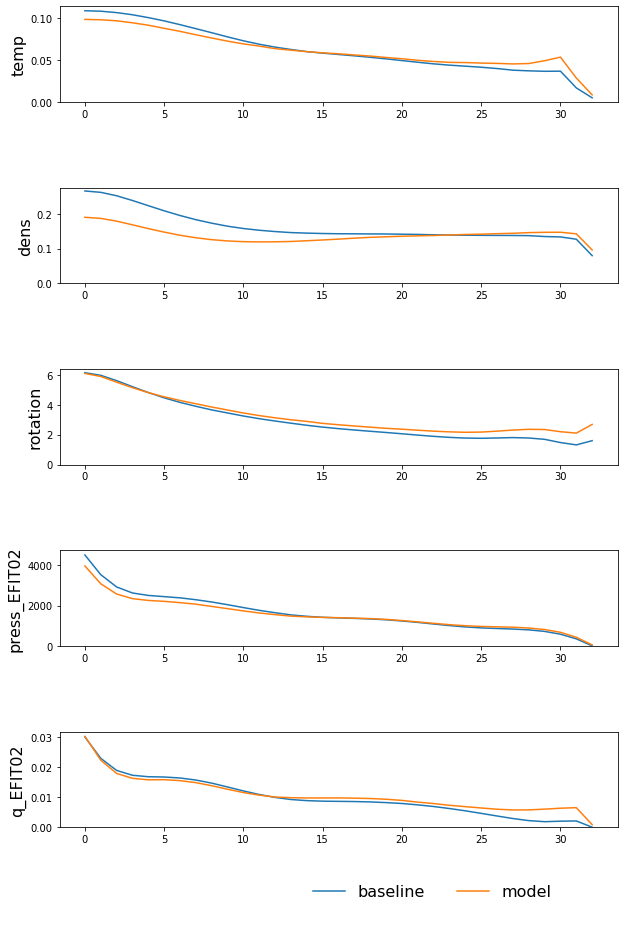

In [26]:
fig, ax = plt.subplots(len(scenario['profile_names']),1,figsize=(10,15))

for i,sig in enumerate(scenario['profile_names']):
    
    ax[i].plot(bas_tot[sig], label='baseline',lw=1.5)
    ax[i].plot(mod_tot[sig], label='model',lw=1.5)
    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(sig,size=16)
plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=16);
fig.show()

In [ ]:
dot = model_to_dot(models[0],show_shapes=True,show_layer_names=True,rankdir='TB')
Image(dot.create_png())
scenarios[0]

In [ ]:
models[-1].get_layer('state_decoder_time_dist').get_weights()

In [ ]:
enc = model.get_layer('state_encoder_time_dist').layer.layers[-1]

In [ ]:
graph = keras.utils.plot_model(enc, 
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB")


In [ ]:
enc.get_weights()

In [ ]:
dec = model.get_layer('state_decoder_time_dist').layer
graph = keras.utils.plot_model(dec, 
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB")


In [ ]:
dec.get_weights()